In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load, Topos
from scipy.optimize import newton
from matplotlib import pyplot as plt
planets = load('de423.bsp')

In [19]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = None
        self.neptune_lambda()
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg()
        self.H = self.gen_H()
        cut = (self.e > 0) * (~np.isnan(self.i))
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        X, Y, Z, r = zip(*map(self.kep_to_xyz, self.a, self.e, self.i,\
                                                  self.arg, self.node, self.M)) # r**2 = X**2 + Y**2 + Z**2
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)
        self.r = np.array(r)
        self.xyz_to_equa(self.X, self.Y, self.Z)
        self.H_to_mag()
        
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self):
        return (0.5*self.phi - 1.5*self.M - self.node + self.lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def H_to_mag(self):
        phase = np.arccos((self.r**2 + self.delta**2 - self.earth_dis**2) / (2 * self.r * self.delta))
        phase_integral = 2/3. * ((1-phase/np.pi)*np.cos(phase) + 1/np.pi*np.sin(phase))
        self.mag = self.H + 2.5 * np.log10((self.r**2 * self.delta**2) / phase_integral)
        
    def neptune_lambda(self):
        neptune = planets[8]
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds        
        self.x_n, self.y_n, self.z_n = neptune.at(t).ecliptic_position().au
        self.lambda_N = np.arctan2(self.y_n, self.x_n) % (2*np.pi)
        #print self.lambda_N 

    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the radius
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, r
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        self.earth_dis = (x_earth**2 + y_earth**2 + z_earth**2)**0.5
        X = X0 - x_earth
        Y = Y0 * np.cos(epsilon) + Z0 * np.sin(epsilon)  - y_earth
        Z = Y0 * np.sin(epsilon) - Z0 * np.cos(epsilon) - z_earth
        self.delta = (X**2 + Y**2+ Z**2)**0.5
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

        

In [20]:
p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0, i_sigma=12)

(array([ 93.,  83.,  98., 101.,  86., 113.,  97.,  96.,  83., 109., 123.,
        110., 101., 107., 103.,  78., 100., 122.,  99.,  98.]),
 array([39.25003862, 39.27002554, 39.29001246, 39.30999938, 39.3299863 ,
        39.34997323, 39.36996015, 39.38994707, 39.40993399, 39.42992091,
        39.44990783, 39.46989476, 39.48988168, 39.5098686 , 39.52985552,
        39.54984244, 39.56982936, 39.58981629, 39.60980321, 39.62979013,
        39.64977705]),
 <a list of 20 Patch objects>)

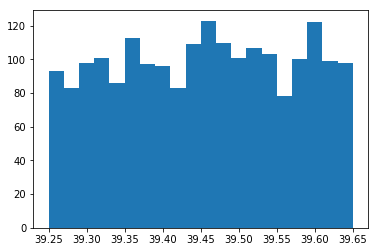

In [21]:
plt.hist(p.a, bins = 20)

(array([  3.,   1.,   9.,  18.,  37.,  83.,  92., 150., 217., 205., 257.,
        230., 237., 184., 115.,  80.,  44.,  19.,  14.,   5.]),
 array([0.26532879, 0.2685726 , 0.27181641, 0.27506021, 0.27830402,
        0.28154782, 0.28479163, 0.28803544, 0.29127924, 0.29452305,
        0.29776685, 0.30101066, 0.30425446, 0.30749827, 0.31074208,
        0.31398588, 0.31722969, 0.32047349, 0.3237173 , 0.32696111,
        0.33020491]),
 <a list of 20 Patch objects>)

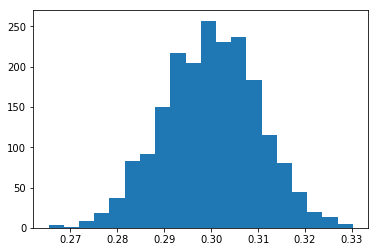

In [22]:
plt.hist(p.e, bins = 20)

(array([ 64., 140., 195., 252., 254., 223., 223., 165., 153., 104.,  70.,
         50.,  41.,  30.,  14.,   3.,   7.,   8.,   1.,   3.]),
 array([ 0.21154926,  2.71814933,  5.22474941,  7.73134948, 10.23794955,
        12.74454962, 15.2511497 , 17.75774977, 20.26434984, 22.77094991,
        25.27754999, 27.78415006, 30.29075013, 32.7973502 , 35.30395028,
        37.81055035, 40.31715042, 42.82375049, 45.33035057, 47.83695064,
        50.34355071]),
 <a list of 20 Patch objects>)

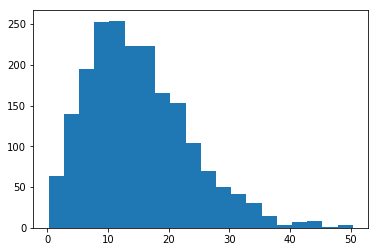

In [23]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([1.000e+00, 2.000e+00, 5.000e+00, 8.000e+00, 3.900e+01, 4.100e+01,
        1.200e+02, 2.550e+02, 5.050e+02, 1.024e+03]),
 array([6.29608948, 6.66645404, 7.03681859, 7.40718315, 7.77754771,
        8.14791226, 8.51827682, 8.88864138, 9.25900593, 9.62937049,
        9.99973504]),
 <a list of 10 Patch objects>)

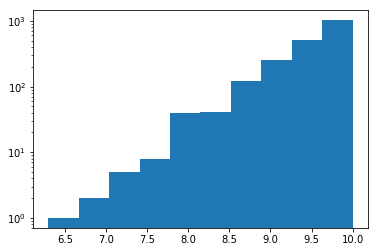

In [24]:
plt.yscale('log', bins = 20)
plt.hist(p.H)

(array([  2.,   4.,  16.,  55., 172., 302., 268., 354., 427., 400.]),
 array([21.74213084, 22.32588025, 22.90962966, 23.49337907, 24.07712848,
        24.66087789, 25.2446273 , 25.82837671, 26.41212612, 26.99587553,
        27.57962494]),
 <a list of 10 Patch objects>)

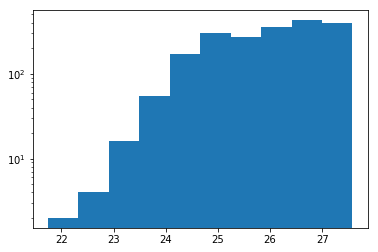

In [25]:
plt.yscale('log', bins = 20)
plt.hist(p.mag)

(array([117., 103.,  96.,  94.,  94., 110., 101.,  94.,  84.,  94., 128.,
         96.,  95.,  95., 100.,  93., 100., 111.,  97.,  98.]),
 array([7.88939157e-04, 6.28783963e-01, 1.25677899e+00, 1.88477401e+00,
        2.51276903e+00, 3.14076406e+00, 3.76875908e+00, 4.39675411e+00,
        5.02474913e+00, 5.65274415e+00, 6.28073918e+00, 6.90873420e+00,
        7.53672922e+00, 8.16472425e+00, 8.79271927e+00, 9.42071429e+00,
        1.00487093e+01, 1.06767043e+01, 1.13046994e+01, 1.19326944e+01,
        1.25606894e+01]),
 <a list of 20 Patch objects>)

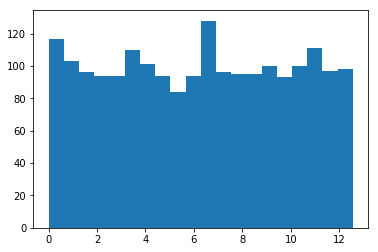

In [26]:
plt.hist(p.M, bins = 20)

(array([104., 101.,  93.,  99., 103.,  89., 108.,  92.,  94.,  98., 112.,
        102., 108.,  95., 112.,  85., 119.,  98.,  99.,  89.]),
 array([4.06639988e-03, 3.17636536e-01, 6.31206672e-01, 9.44776808e-01,
        1.25834694e+00, 1.57191708e+00, 1.88548722e+00, 2.19905735e+00,
        2.51262749e+00, 2.82619762e+00, 3.13976776e+00, 3.45333790e+00,
        3.76690803e+00, 4.08047817e+00, 4.39404830e+00, 4.70761844e+00,
        5.02118858e+00, 5.33475871e+00, 5.64832885e+00, 5.96189899e+00,
        6.27546912e+00]),
 <a list of 20 Patch objects>)

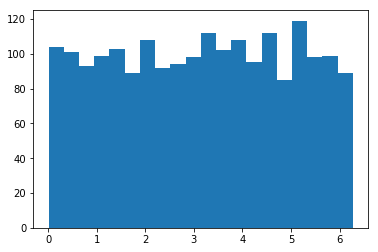

In [27]:
plt.hist(p.arg, bins = 20)

(array([100.,  87.,  85.,  96.,  99.,  91.,  90.,  87.,  92., 103., 101.,
        121., 111., 111., 106., 120.,  89., 101., 102., 108.]),
 array([9.97297115e-04, 3.14972535e-01, 6.28947773e-01, 9.42923011e-01,
        1.25689825e+00, 1.57087349e+00, 1.88484873e+00, 2.19882396e+00,
        2.51279920e+00, 2.82677444e+00, 3.14074968e+00, 3.45472491e+00,
        3.76870015e+00, 4.08267539e+00, 4.39665063e+00, 4.71062587e+00,
        5.02460110e+00, 5.33857634e+00, 5.65255158e+00, 5.96652682e+00,
        6.28050206e+00]),
 <a list of 20 Patch objects>)

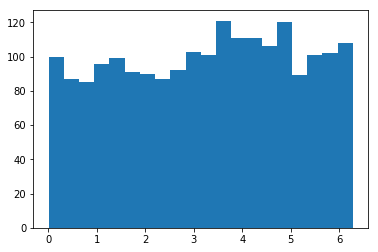

In [28]:
plt.hist(p.node, bins = 20)

(array([ 94.,  96., 101., 103.,  99.,  95., 105., 102.,  94., 108.,  96.,
        114., 126.,  88.,  96.,  95.,  89.,  96.,  98., 105.]),
 array([1.72319100e-03, 3.15790539e-01, 6.29857887e-01, 9.43925235e-01,
        1.25799258e+00, 1.57205993e+00, 1.88612728e+00, 2.20019463e+00,
        2.51426197e+00, 2.82832932e+00, 3.14239667e+00, 3.45646402e+00,
        3.77053137e+00, 4.08459871e+00, 4.39866606e+00, 4.71273341e+00,
        5.02680076e+00, 5.34086810e+00, 5.65493545e+00, 5.96900280e+00,
        6.28307015e+00]),
 <a list of 20 Patch objects>)

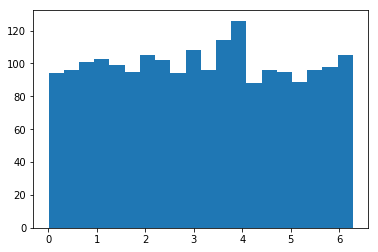

In [29]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([ 10.,  21.,  32.,  66.,  86., 106., 131., 144., 142., 162., 161.,
        183., 153., 155., 141., 115.,  69.,  69.,  34.,  20.]),
 array([3.10861334, 3.11180248, 3.11499162, 3.11818076, 3.12136991,
        3.12455905, 3.12774819, 3.13093733, 3.13412647, 3.13731561,
        3.14050475, 3.14369389, 3.14688303, 3.15007217, 3.15326131,
        3.15645045, 3.15963959, 3.16282873, 3.16601788, 3.16920702,
        3.17239616]),
 <a list of 20 Patch objects>)

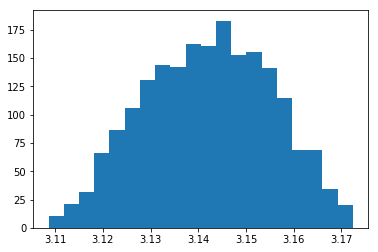

In [30]:
plt.hist(p.phi, bins = 20)

In [31]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [32]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

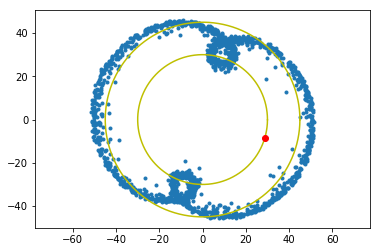

In [33]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

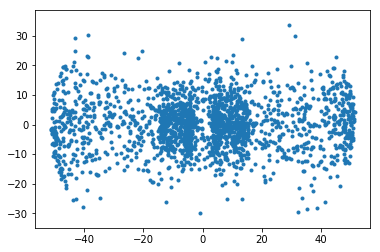

In [34]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

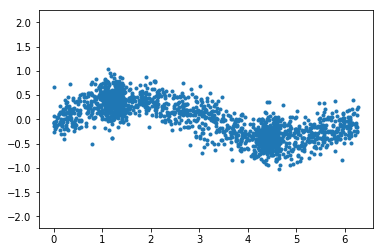

In [35]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')